# Data augmentation on the mnist roman dataset for Data-Centric competition

#### Refer to https://worksheets.codalab.org/worksheets/0x7a8721f11e61436e93ac8f76da83f0e6

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import json
import sys

import PIL
import PIL.Image
import pathlib
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers

In [2]:
print(tf.__version__)

2.5.0


In [3]:
def plot_dataset_samples(dataset, figsize=10):
    plt.figure(figsize=(figsize, figsize))
    for images, labels in dataset.take(1):
        for i in range(images.shape[0]):
            ax = plt.subplot(2, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[list(labels[i]).index(1)])
            plt.axis("off")

In [4]:
def do_augmentation_randomflip(dataset, data_aug_type):
    data_augmentation = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip(data_aug_type),])
    return dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

In [5]:
def do_augmentation_random_rotation(dataset, data_rotation_factor=0.2):
    data_augmentation = tf.keras.Sequential([layers.experimental.preprocessing.RandomRotation(data_rotation_factor),])
    return dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

In [6]:
data_dir = 'label_book'

In [7]:
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.png')))
print(f'The folder {data_dir} contains {image_count} pictures of roman numbers')

The foleder label_book contains 52 pictures of roman numbers


Let's visualize one roman number as example.

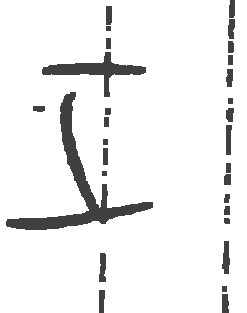

In [8]:
roman_i = list(data_dir.glob('i/*'))
PIL.Image.open(str(roman_i[0]))

Let's ingest the roman numbers by the API 'image_dataset_from_directory'. The labels will be inferred by the 'class_names' parameter.

In [9]:
roman_numbers = "label_book"
class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"]
batch_size = 8
tf.random.set_seed(123)

In [10]:
numbers_ds = tf.keras.preprocessing.image_dataset_from_directory(
    roman_numbers,
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
    shuffle=True,
    seed=123,
    batch_size=batch_size,
    image_size=(247, 313),
)

Found 52 files belonging to 10 classes.


In [11]:
class_names = numbers_ds.class_names
print(f"The class names are {class_names}")

The class names are ['i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x']


In [12]:
for image_batch, labels_batch in numbers_ds:
    print("Batch shape", image_batch.shape)
    print("Labels shape", labels_batch.shape)
    break

numbers_of_batches = numbers_ds.cardinality().numpy()
print("Number of batches:", numbers_of_batches)


Batch shape (8, 247, 313, 3)
Labels shape (8, 10)
Number of batches: 7


## Visualize the data

Here are the first 8 images from the dataset.

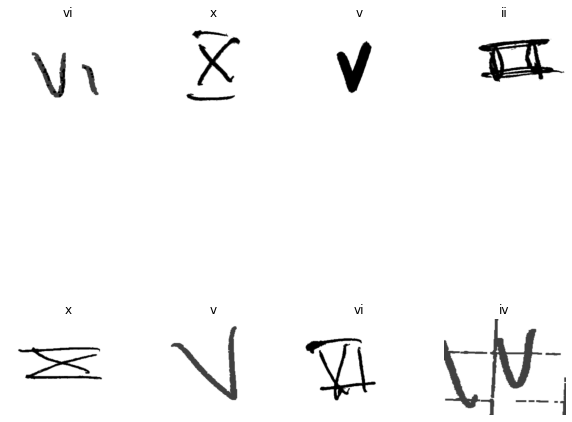

In [13]:
plot_dataset_samples(numbers_ds)

## Data augmentation

Now all the images have been loaded. We are ready to make some kind of data augmentation.\
Please refer to the following tutorial https://www.tensorflow.org/tutorials/images/data_augmentation.

### Horizontal flip

I    -->  I\
II   -->  II\
III  --> III\
IV   --> VI\
V    --> V\
VI   --> IV\
VII  --> IIV (not valid)\
VIII --> IIIV (not valid)\
IX   --> XI (not valid)\
X    --> X

So there are some exceptions that have to be taken into account when we will store the augmented data:

In [14]:
horizontal_exceptions = ['vii', 'viii', 'ix']

In [15]:
numbers_horizontal_ds = do_augmentation_randomflip(numbers_ds, "horizontal")

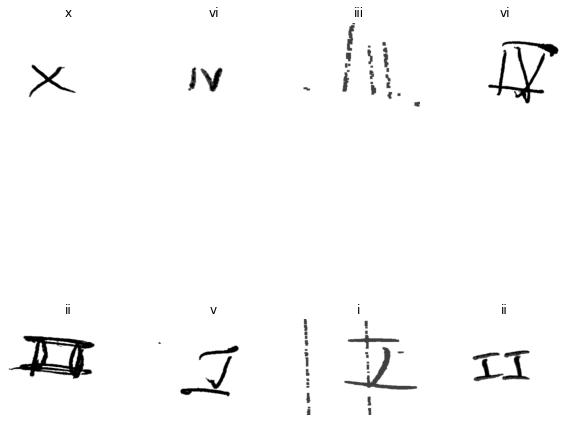

In [16]:
plot_dataset_samples(numbers_horizontal_ds)

### Vertical flip

I    -->  I\
II   -->  II\
III  --> III\
IV   --> not valid\
V    --> not valid\
VI   --> not valid\
VII  --> not valid\
VIII --> not valid\
IX   --> IX\
X    --> X

So there are some exceptions that have to be taken into account when we will store the augmented data:

In [17]:
vertical_exceptions = ['iv', 'v', 'vi', 'vii', 'viii']

In [18]:
numbers_vertical_ds = do_augmentation_randomflip(numbers_ds, "vertical")

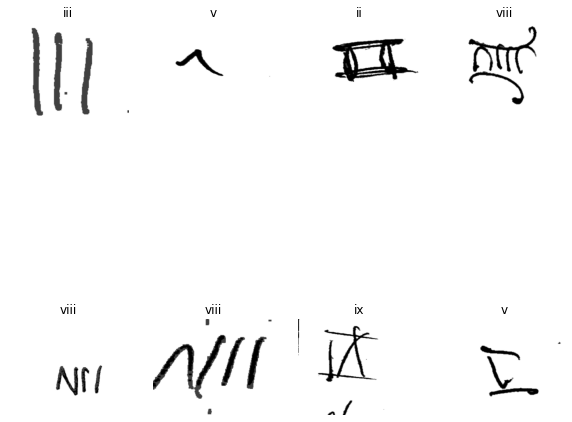

In [19]:
plot_dataset_samples(numbers_vertical_ds)

Not let's save only the images that correspond to a real roman numbers.

In [20]:
import shutil
import uuid

augmentation_dir = 'augmentation/'
if os.path.exists(augmentation_dir):
    shutil.rmtree(augmentation_dir)

if not os.path.exists(augmentation_dir):
    os.makedirs(augmentation_dir)

for cl in class_names:
    if not os.path.exists(os.path.join(augmentation_dir, cl)):
        os.makedirs(os.path.join(augmentation_dir, cl))

In [21]:
def dataset_save(dataset, directory, exceptions=[]):
    for images, labels in dataset:
        for i in range(images.shape[0]):
            cl = class_names[list(labels[i]).index(1)]
            if cl not in exceptions:
                filepath = os.path.join(directory + cl) + '/' + str(uuid.uuid4()) + '.png'
                tf.keras.preprocessing.image.save_img(filepath , images[i].numpy().astype("uint8"))

In [22]:
dataset_save(numbers_ds, augmentation_dir)
dataset_save(numbers_horizontal_ds, augmentation_dir, horizontal_exceptions)
dataset_save(numbers_vertical_ds, augmentation_dir, vertical_exceptions)


### Random Rotation

In [23]:
numbers_rotation_ds = do_augmentation_random_rotation(numbers_ds, 0.1)

In [24]:
dataset_save(numbers_rotation_ds, augmentation_dir)

In [25]:
numbers_rotation_ds = do_augmentation_random_rotation(numbers_horizontal_ds, 0.1)

In [26]:
dataset_save(numbers_rotation_ds, augmentation_dir)

In [27]:
numbers_rotation_ds = do_augmentation_random_rotation(numbers_vertical_ds, 0.1)

In [28]:
dataset_save(numbers_rotation_ds, augmentation_dir)